In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


# PRE PROCESSING

In [2]:
DATA_PATH = '/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [3]:
import os
print(os.listdir('/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules'))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules'

In [5]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

FileNotFoundError: File /kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/module_metadata.json does not exist


Unique values and their frequency:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


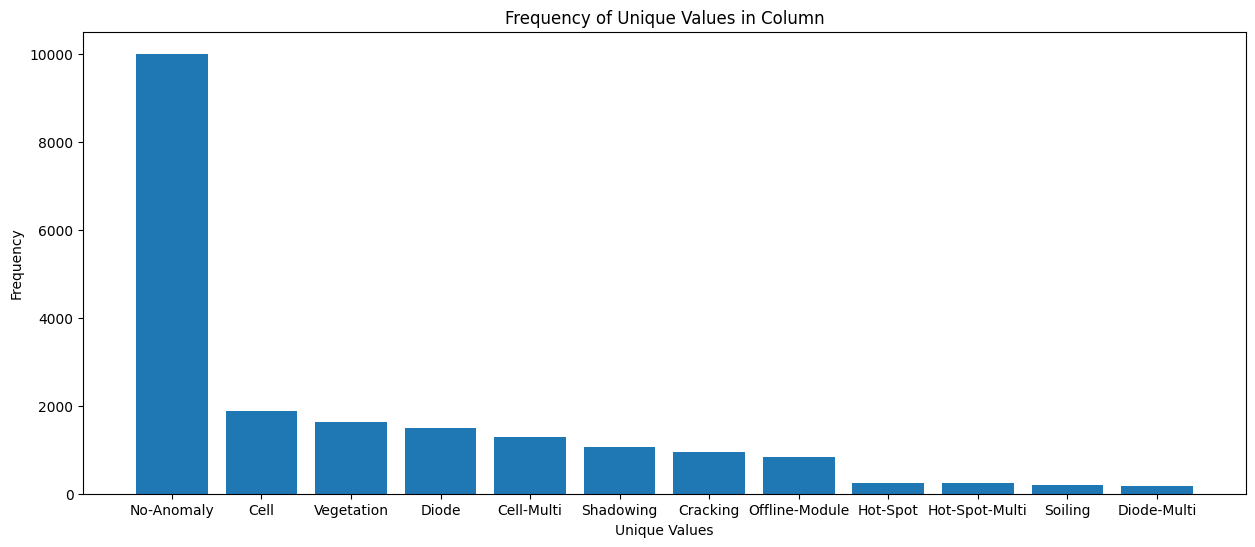

In [4]:
# Get unique values and their frequency
unique_values = df['anomaly_class'].value_counts()
print("\nUnique values and their frequency:")
print(unique_values)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()

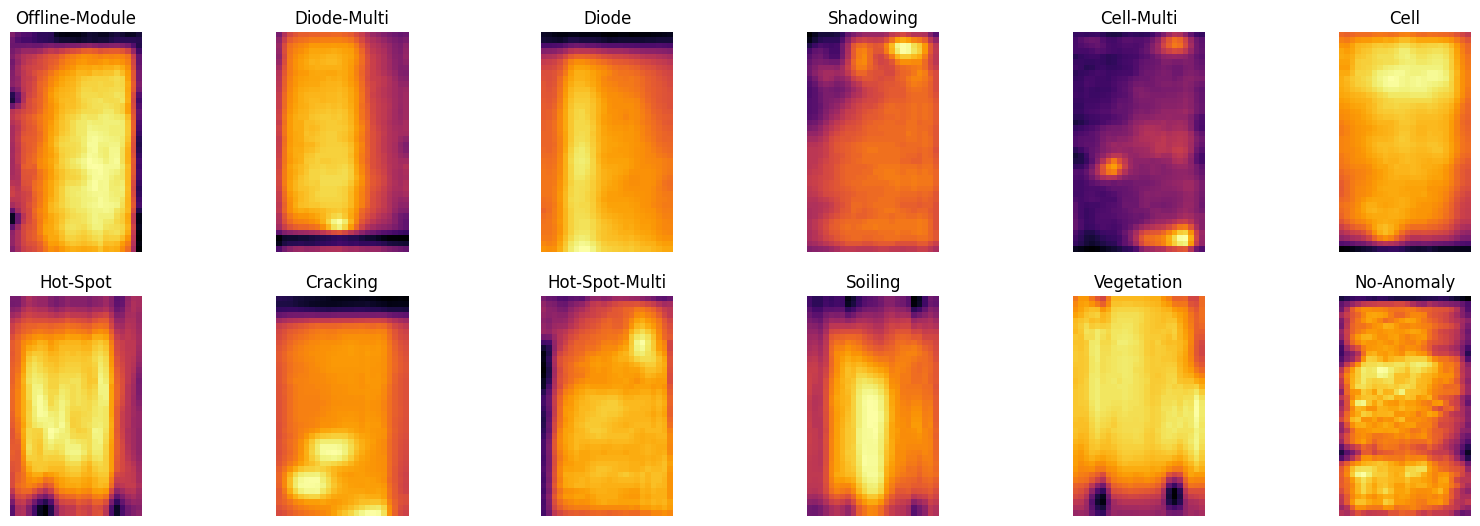

In [5]:

# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]
    
    image = cv2.imread(sample['image_filepath'], 0)
    
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()

**Splitting images based on module properties**

As mentioned in readme of the dataset, the classes Hot-spot and Hot-spot Multi are anomalies from Thin film modules. These types of solar panels are less used in the industry when compared to (monocrystalline or polycrystalline) silicon modules and work completely different. But neither in Raptor maps github repository or in the dataset paper there is information about how many modules belong to the crystalline type and how much to the thin film type in the No-Anomaly class.

In [6]:
crystal_df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
crystal_df

,image_filepath,anomaly_class
0,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
1,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
2,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
3,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
4,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
...,...,...
19995,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19996,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19997,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19998,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly


In [7]:
thin_film_df = df.query('anomaly_class == ("Hot-Spot", "Hot-Spot-Multi")')
thin_film_df

,image_filepath,anomaly_class
6722,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6723,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6724,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6725,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6726,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
...,...,...
8152,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8153,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8154,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8155,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi


**MODEL FOR PREDICTION**

In [8]:
crystal_df['image_filepath']

0        ../input/infrared-solar-modules/2020-02-14_Inf...
1        ../input/infrared-solar-modules/2020-02-14_Inf...
2        ../input/infrared-solar-modules/2020-02-14_Inf...
3        ../input/infrared-solar-modules/2020-02-14_Inf...
4        ../input/infrared-solar-modules/2020-02-14_Inf...
                               ...                        
19995    ../input/infrared-solar-modules/2020-02-14_Inf...
19996    ../input/infrared-solar-modules/2020-02-14_Inf...
19997    ../input/infrared-solar-modules/2020-02-14_Inf...
19998    ../input/infrared-solar-modules/2020-02-14_Inf...
19999    ../input/infrared-solar-modules/2020-02-14_Inf...
Name: image_filepath, Length: 19505, dtype: object

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(crystal_df, train_size=0.8, shuffle=True, random_state=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D

In [11]:
import tensorflow as tf  # Import TensorFlow

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 12484 validated image filenames belonging to 10 classes.
Found 3120 validated image filenames belonging to 10 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3901 validated image filenames belonging to 10 classes.


# RESNET 50

In [14]:
# Load pretrained ResNet50 model without the top classification layer
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze last few layers for fine-tuning
for layer in pretrained_model.layers[-3:]:
    layer.trainable = True

# Add custom classification layers
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model with a low learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 

94765736/94765736 [==============================] - 4s 0us/step


Epoch 1/30
391/391 [==============================] - 160s 308ms/step - loss: 1.3626 - accuracy: 0.5776 - val_loss: 1.2311 - val_accuracy: 0.6397
Epoch 2/30
391/391 [==============================] - 78s 198ms/step - loss: 0.8253 - accuracy: 0.7417 - val_loss: 0.8245 - val_accuracy: 0.7417
Epoch 3/30
391/391 [==============================] - 78s 198ms/step - loss: 0.6098 - accuracy: 0.8070 - val_loss: 0.7202 - val_accuracy: 0.7721
Epoch 4/30
391/391 [==============================] - 77s 198ms/step - loss: 0.4586 - accuracy: 0.8556 - val_loss: 0.7088 - val_accuracy: 0.7853
Epoch 5/30
391/391 [==============================] - 77s 196ms/step - loss: 0.3364 - accuracy: 0.8961 - val_loss: 0.7167 - val_accuracy: 0.7949
Epoch 6/30
391/391 [==============================] - 77s 197ms/step - loss: 0.2458 - accuracy: 0.9296 - val_loss: 0.7568 - val_accuracy: 0.7840
Epoch 7/30
391/391 [==============================] - 77s 198ms/step - loss: 0.1672 - accuracy: 0.9549 - val_loss: 0.7466 - val_a

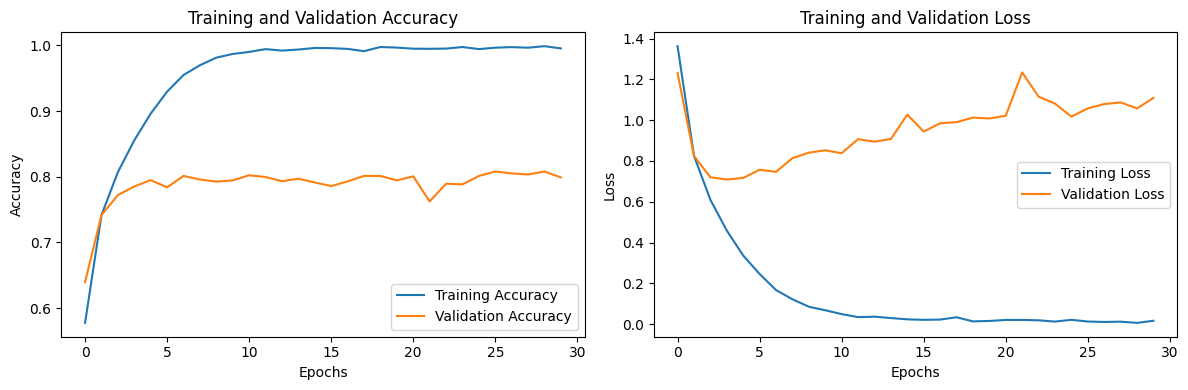

In [15]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,  # Number of epochs can be adjusted based on results
    batch_size=32
)

# Evaluate on test set
results = model.evaluate(test_images, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1] * 100:.2f}%")

# Get predictions
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels
y_true_labels = test_images.classes

from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=test_images.class_indices.keys()))


# Plotting training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[1.1639230251312256, 0.7877467274665833]
Test Accuracy: 78.77%


In [17]:
# Load pretrained ResNet50 model without the top classification layer
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze last few layers for fine-tuning
for layer in pretrained_model.layers[-3:]:
    layer.trainable = True

# Add custom classification layers
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model with a low learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 

Epoch 1/50
391/391 [==============================] - 113s 199ms/step - loss: 1.4434 - accuracy: 0.5625 - val_loss: 1.3424 - val_accuracy: 0.6285
Epoch 2/50
391/391 [==============================] - 77s 197ms/step - loss: 0.8773 - accuracy: 0.7260 - val_loss: 0.8243 - val_accuracy: 0.7478
Epoch 3/50
391/391 [==============================] - 77s 198ms/step - loss: 0.6471 - accuracy: 0.7878 - val_loss: 0.7630 - val_accuracy: 0.7583
Epoch 4/50
391/391 [==============================] - 77s 197ms/step - loss: 0.4890 - accuracy: 0.8410 - val_loss: 0.7039 - val_accuracy: 0.7731
Epoch 5/50
391/391 [==============================] - 78s 198ms/step - loss: 0.3629 - accuracy: 0.8820 - val_loss: 0.7394 - val_accuracy: 0.7760
Epoch 6/50
391/391 [==============================] - 77s 198ms/step - loss: 0.2550 - accuracy: 0.9253 - val_loss: 0.6984 - val_accuracy: 0.7837
Epoch 7/50
391/391 [==============================] - 77s 198ms/step - loss: 0.1810 - accuracy: 0.9531 - val_loss: 0.7627 - val_a

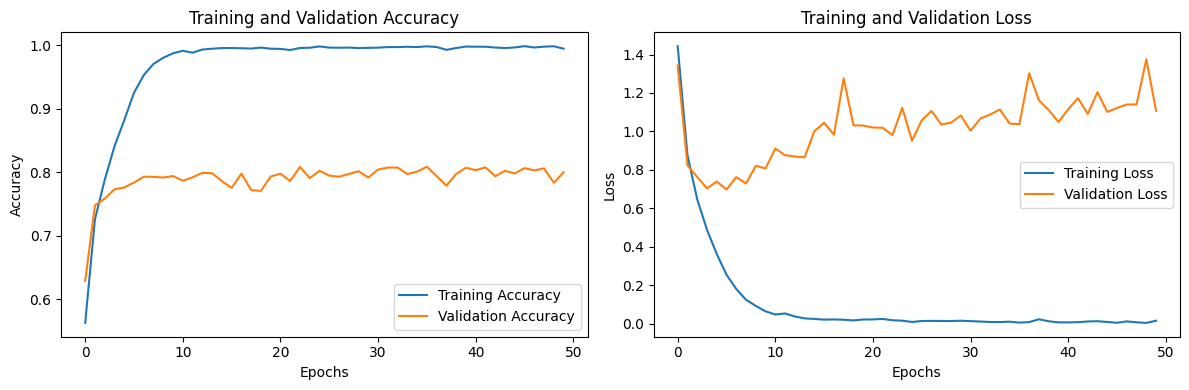

In [18]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,  # Number of epochs can be adjusted based on results
    batch_size=32
)

# Evaluate on test set
results = model.evaluate(test_images, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1] * 100:.2f}%")

# Get predictions
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels
y_true_labels = test_images.classes

from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=test_images.class_indices.keys()))


# Plotting training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()